In [8]:
import torch
import glob
from torch.utils.data import Dataset
from torchvision import transforms as trf
from torch.utils.data import random_split, DataLoader
import os
import zipfile
#from glob import glob
from PIL import Image
import numpy as np


import matplotlib.pyplot as plt

# CustomDataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, root, transformation = None):
        self.transformation = transformation
        self.im_paths = glob.glob(os.path.join(root, "/kaggle/input/rice-leaf-disease-classification-dataset/Rice Leaf  Disease Dataset/*/*.*"))
        print(len(self.im_paths))
        
        self.cls_names = []
        for idx, im_path in enumerate(self.im_paths):
            dirname = os.path.dirname(im_path)
            cls_name = dirname.split('/')[-1]
            
            if cls_name not in self.cls_names:
                self.cls_names.append(cls_name)
                
        self.classes = {idx: cls_name for idx, cls_name in enumerate(self.cls_names)}
        print("Classes:", self.classes)
        
        
    def __len__(self):
        return len(self.im_paths)
    
    def get_classes(self):
        return self.classes
    
    
    
    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        
        for idx, (cls_num, cls_name) in enumerate(self.classes.items()):
            if cls_name in im_path:
                gt = cls_num
                break
                
        im = Image.open(im_path).convert('RGB')
        
        if self.transformation is not None:
            im = self.transformation(im)
            
        return im, gt
        
tfs = trf.Compose([
    trf.Resize((224, 224)),
    trf.ToTensor(),
    trf.Normalize(0.5, 0.5)
])

ds = CustomDataset(root= 'data', transformation=tfs)
classes = ds.get_classes()


image, label = ds[0]
print(image.shape)
len(classes)

595
Classes: {0: 'Tungro', 1: 'Material Leaf Blight', 2: 'sheath_blight', 3: 'False smut', 4: 'Rice Blast', 5: 'Healthy', 6: 'Stem rot', 7: 'Brown Spot'}
torch.Size([3, 224, 224])


8

# Visualize

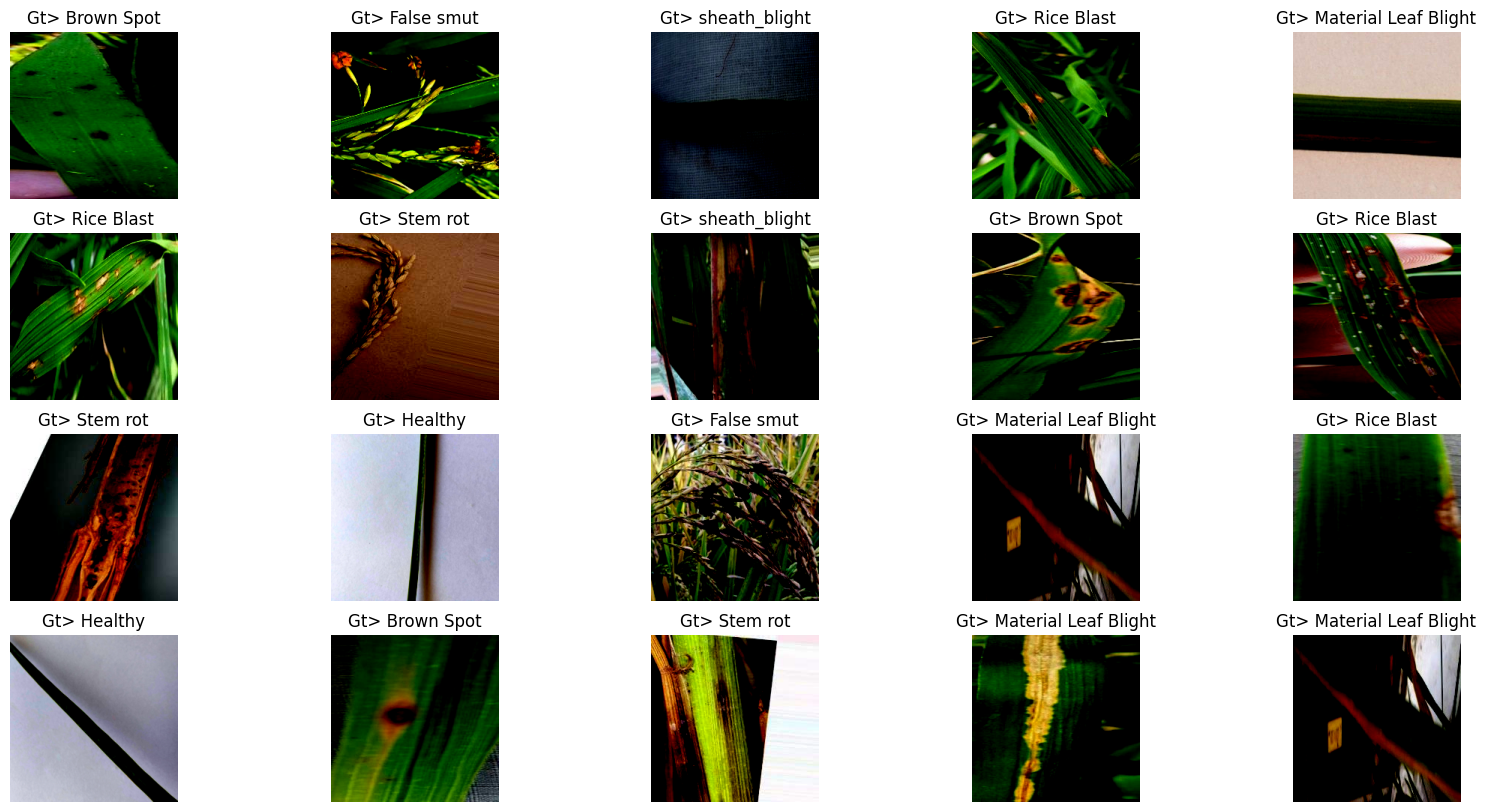

In [10]:
rows, im_num = 4, 20
indices = np.random.randint(low=0, high=len(ds), size=im_num)

plt.figure(figsize=(20,10))
for i, idx in enumerate(indices):
    im, gt = ds[idx]
    plt.subplot(rows, im_num // rows, i+1)
    plt.imshow(im.permute(1,2,0))
    plt.title('Gt> 'f'{classes[gt]}')
    plt.axis('off')

# Dataloader

In [11]:
def dataloader(root, transformation, batch, split = [0.8, 0.1, 0.1]):
    assert sum(split)==1
    
    ds = CustomDataset(root=root, transformation=transformation)
    
    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    
    tr_ds, vl_ds, ts_ds = random_split(ds, [tr_len, val_len, test_len])
    
    print(f'Trainset: {len(tr_ds)}')
    print(f'Validationset: {len(vl_ds)}')
    print(f'Testset: {len(ts_ds)}')
    
    
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch, shuffle=True)
    val_dl = DataLoader(dataset=vl_ds, batch_size=batch, shuffle=False)
    test_dl = DataLoader(dataset=ts_ds,batch_size= batch, shuffle=False)
    
    return tr_dl, val_dl, test_dl
    
tr_dl, val_dl, test_dl = dataloader(root='data', batch=16, transformation=tfs)
print("\n")

print(f'Train_dl: {len(tr_dl)}')
print(f'Val_dl: {len(val_dl)}')
print(f'Test_dl: {len(test_dl)}')

595
Classes: {0: 'Tungro', 1: 'Material Leaf Blight', 2: 'sheath_blight', 3: 'False smut', 4: 'Rice Blast', 5: 'Healthy', 6: 'Stem rot', 7: 'Brown Spot'}
Trainset: 476
Validationset: 59
Testset: 60


Train_dl: 30
Val_dl: 4
Test_dl: 4


In [12]:
import timm
import torch.nn as nn
timm.list_models( 'resnet18')

['resnet18']

In [13]:
model = timm.create_model('resnet18', pretrained=True)


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [14]:
def train_setup(model): 
    return model.to("cuda"), 20, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = model.parameters(), lr = 0.001)

model, epochs, device, loss_fn, optimizer = train_setup(model)

# Training code

In [16]:
from tqdm import tqdm

patience = 4  # stop training if validation loss does not improve for 3 epochs
best_val_loss = float('inf')
best_val_acc = 0
improvement = 0

# Initialize lists to store training and validation losses and accuracies
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# Loop over epochs
for epoch in range(epochs):
    epoch_loss, epoch_acc, total = 0, 0, 0
    
    # Training loop
    model.train()
    for idx, batch in tqdm(enumerate(tr_dl)):
        ims, gts = batch
        ims, gts = ims.to(device), gts.to(device)
        total += ims.shape[0]
        
        # Forward pass
        preds = model(ims)
        loss = loss_fn(preds, gts)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Compute accuracy
        _, pred_cls = torch.max(preds.data, dim=1)
        epoch_acc += (pred_cls == gts).sum().item()
        epoch_loss += loss.item()
        
    # Calculate average training loss and accuracy for the epoch
    tr_loss = epoch_loss / len(tr_dl)
    train_losses.append(tr_loss)
    train_accs.append(epoch_acc / total)
    
    # Print training metrics
    print(f"Epoch {epoch + 1} train process is finished")
    print(f"Epoch {epoch + 1} train loss -> {tr_loss:.3f}")
    print(f"Epoch {epoch + 1} train accuracy -> {epoch_acc / total:.3f}")
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            val_total += ims.shape[0]

            # Forward pass
            preds = model(ims)
            loss = loss_fn(preds, gts)

            # Compute validation accuracy
            _, pred_cls = torch.max(preds.data, dim=1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()
        
        # Calculate average validation loss and accuracy for the epoch
        val_loss = val_epoch_loss / len(val_dl)
        val_acc = val_epoch_acc / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print validation metrics
        print(f"Epoch {epoch + 1} validation is finished")
        print(f"Epoch {epoch + 1} validation loss -> {val_loss:.3f}")
        print(f"Epoch {epoch + 1} validation accuracy -> {val_acc:.3f}")
        
        # Save the model if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            improvement = 0
            torch.save(model.state_dict(), 'resnet_50.pth')
        else:
            improvement += 1
            if improvement >= patience:
                print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
                break


30it [00:10,  2.84it/s]


Epoch 1 train process is finished
Epoch 1 train loss -> 0.382
Epoch 1 train accuracy -> 0.891
Epoch 1 validation is finished
Epoch 1 validation loss -> 0.295
Epoch 1 validation accuracy -> 0.949


30it [00:10,  2.83it/s]


Epoch 2 train process is finished
Epoch 2 train loss -> 0.199
Epoch 2 train accuracy -> 0.947
Epoch 2 validation is finished
Epoch 2 validation loss -> 0.394
Epoch 2 validation accuracy -> 0.915


30it [00:10,  2.81it/s]


Epoch 3 train process is finished
Epoch 3 train loss -> 0.086
Epoch 3 train accuracy -> 0.979
Epoch 3 validation is finished
Epoch 3 validation loss -> 0.280
Epoch 3 validation accuracy -> 0.915


30it [00:10,  2.85it/s]


Epoch 4 train process is finished
Epoch 4 train loss -> 0.040
Epoch 4 train accuracy -> 0.992
Epoch 4 validation is finished
Epoch 4 validation loss -> 0.189
Epoch 4 validation accuracy -> 0.932


30it [00:10,  2.82it/s]


Epoch 5 train process is finished
Epoch 5 train loss -> 0.039
Epoch 5 train accuracy -> 0.994
Epoch 5 validation is finished
Epoch 5 validation loss -> 0.315
Epoch 5 validation accuracy -> 0.915


30it [00:10,  2.81it/s]


Epoch 6 train process is finished
Epoch 6 train loss -> 0.039
Epoch 6 train accuracy -> 0.994
Epoch 6 validation is finished
Epoch 6 validation loss -> 0.213
Epoch 6 validation accuracy -> 0.932


30it [00:10,  2.87it/s]


Epoch 7 train process is finished
Epoch 7 train loss -> 0.039
Epoch 7 train accuracy -> 0.987
Epoch 7 validation is finished
Epoch 7 validation loss -> 0.128
Epoch 7 validation accuracy -> 0.966


30it [00:10,  2.78it/s]


Epoch 8 train process is finished
Epoch 8 train loss -> 0.049
Epoch 8 train accuracy -> 0.983
Epoch 8 validation is finished
Epoch 8 validation loss -> 0.131
Epoch 8 validation accuracy -> 0.966


30it [00:10,  2.81it/s]


Epoch 9 train process is finished
Epoch 9 train loss -> 0.015
Epoch 9 train accuracy -> 0.998
Epoch 9 validation is finished
Epoch 9 validation loss -> 0.077
Epoch 9 validation accuracy -> 0.966


30it [00:10,  2.87it/s]


Epoch 10 train process is finished
Epoch 10 train loss -> 0.019
Epoch 10 train accuracy -> 0.994
Epoch 10 validation is finished
Epoch 10 validation loss -> 0.067
Epoch 10 validation accuracy -> 0.983


30it [00:10,  2.85it/s]


Epoch 11 train process is finished
Epoch 11 train loss -> 0.008
Epoch 11 train accuracy -> 1.000
Epoch 11 validation is finished
Epoch 11 validation loss -> 0.058
Epoch 11 validation accuracy -> 0.983


30it [00:10,  2.90it/s]


Epoch 12 train process is finished
Epoch 12 train loss -> 0.006
Epoch 12 train accuracy -> 1.000
Epoch 12 validation is finished
Epoch 12 validation loss -> 0.051
Epoch 12 validation accuracy -> 0.983


30it [00:10,  2.86it/s]


Epoch 13 train process is finished
Epoch 13 train loss -> 0.004
Epoch 13 train accuracy -> 1.000
Epoch 13 validation is finished
Epoch 13 validation loss -> 0.043
Epoch 13 validation accuracy -> 0.983


30it [00:10,  2.83it/s]


Epoch 14 train process is finished
Epoch 14 train loss -> 0.005
Epoch 14 train accuracy -> 1.000
Epoch 14 validation is finished
Epoch 14 validation loss -> 0.025
Epoch 14 validation accuracy -> 1.000


30it [00:10,  2.85it/s]


Epoch 15 train process is finished
Epoch 15 train loss -> 0.014
Epoch 15 train accuracy -> 0.998
Epoch 15 validation is finished
Epoch 15 validation loss -> 0.058
Epoch 15 validation accuracy -> 0.966


30it [00:10,  2.82it/s]


Epoch 16 train process is finished
Epoch 16 train loss -> 0.012
Epoch 16 train accuracy -> 0.994
Epoch 16 validation is finished
Epoch 16 validation loss -> 0.033
Epoch 16 validation accuracy -> 0.983


30it [00:10,  2.86it/s]


Epoch 17 train process is finished
Epoch 17 train loss -> 0.007
Epoch 17 train accuracy -> 0.998
Epoch 17 validation is finished
Epoch 17 validation loss -> 0.033
Epoch 17 validation accuracy -> 0.983


30it [00:10,  2.84it/s]


Epoch 18 train process is finished
Epoch 18 train loss -> 0.008
Epoch 18 train accuracy -> 0.998
Epoch 18 validation is finished
Epoch 18 validation loss -> 0.040
Epoch 18 validation accuracy -> 0.983
No improvement in validation loss for 4 epochs. Stopping early.


# Plot the loss

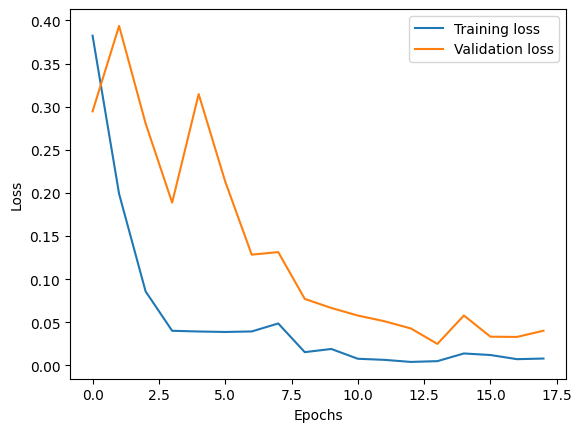

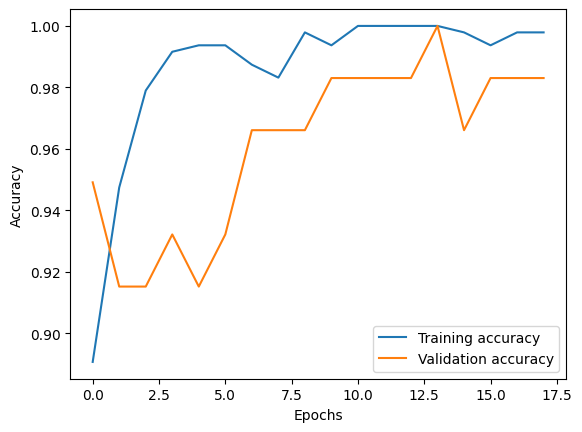

In [17]:
# plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Inference 

In [18]:
ims, gts = next(iter(test_dl))

preds, images, lbls = [], [], []
for im, gt in zip(ims, gts):
    im, gt = im.to(device), gt.to(device)
    _, pred = torch.max(model(im.unsqueeze(0)), dim = 1)
    images.append(im)
    preds.append(pred.item())
    lbls.append(gt)
print(len(preds))
print(type(gt), gt)
print(type(pred), pred)

16
<class 'torch.Tensor'> tensor(5, device='cuda:0')
<class 'torch.Tensor'> tensor([5], device='cuda:0')


In [20]:
def tensor_2_im(t): return (t * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)
import pandas as pd
import numpy as np


classnames = ds.classes
print(type(classnames))

<class 'dict'>


In [21]:
import random

invTrans = trf.Compose([ trf.Normalize(mean = [ 0. ], std = [ 1/0.5]), trf.Normalize(mean = [ -0.5 ], std = [ 1. ])  ])


def visualize_test(ims, num_ims, row):
    
    plt.figure(figsize = (20, 20))
    indexes = [random.randint(0, len(ims) - 1) for _ in range(num_ims)]
    for idx, indeks in enumerate(indexes):      
        im = ims[indeks]
        gt = lbls[indeks].item()
        pred = preds[indeks]
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(invTrans(im)), cmap='gray')
        plt.axis('off')
        plt.title(f"GT -> {classnames[gt]}; Pred -> {classnames[pred]}")

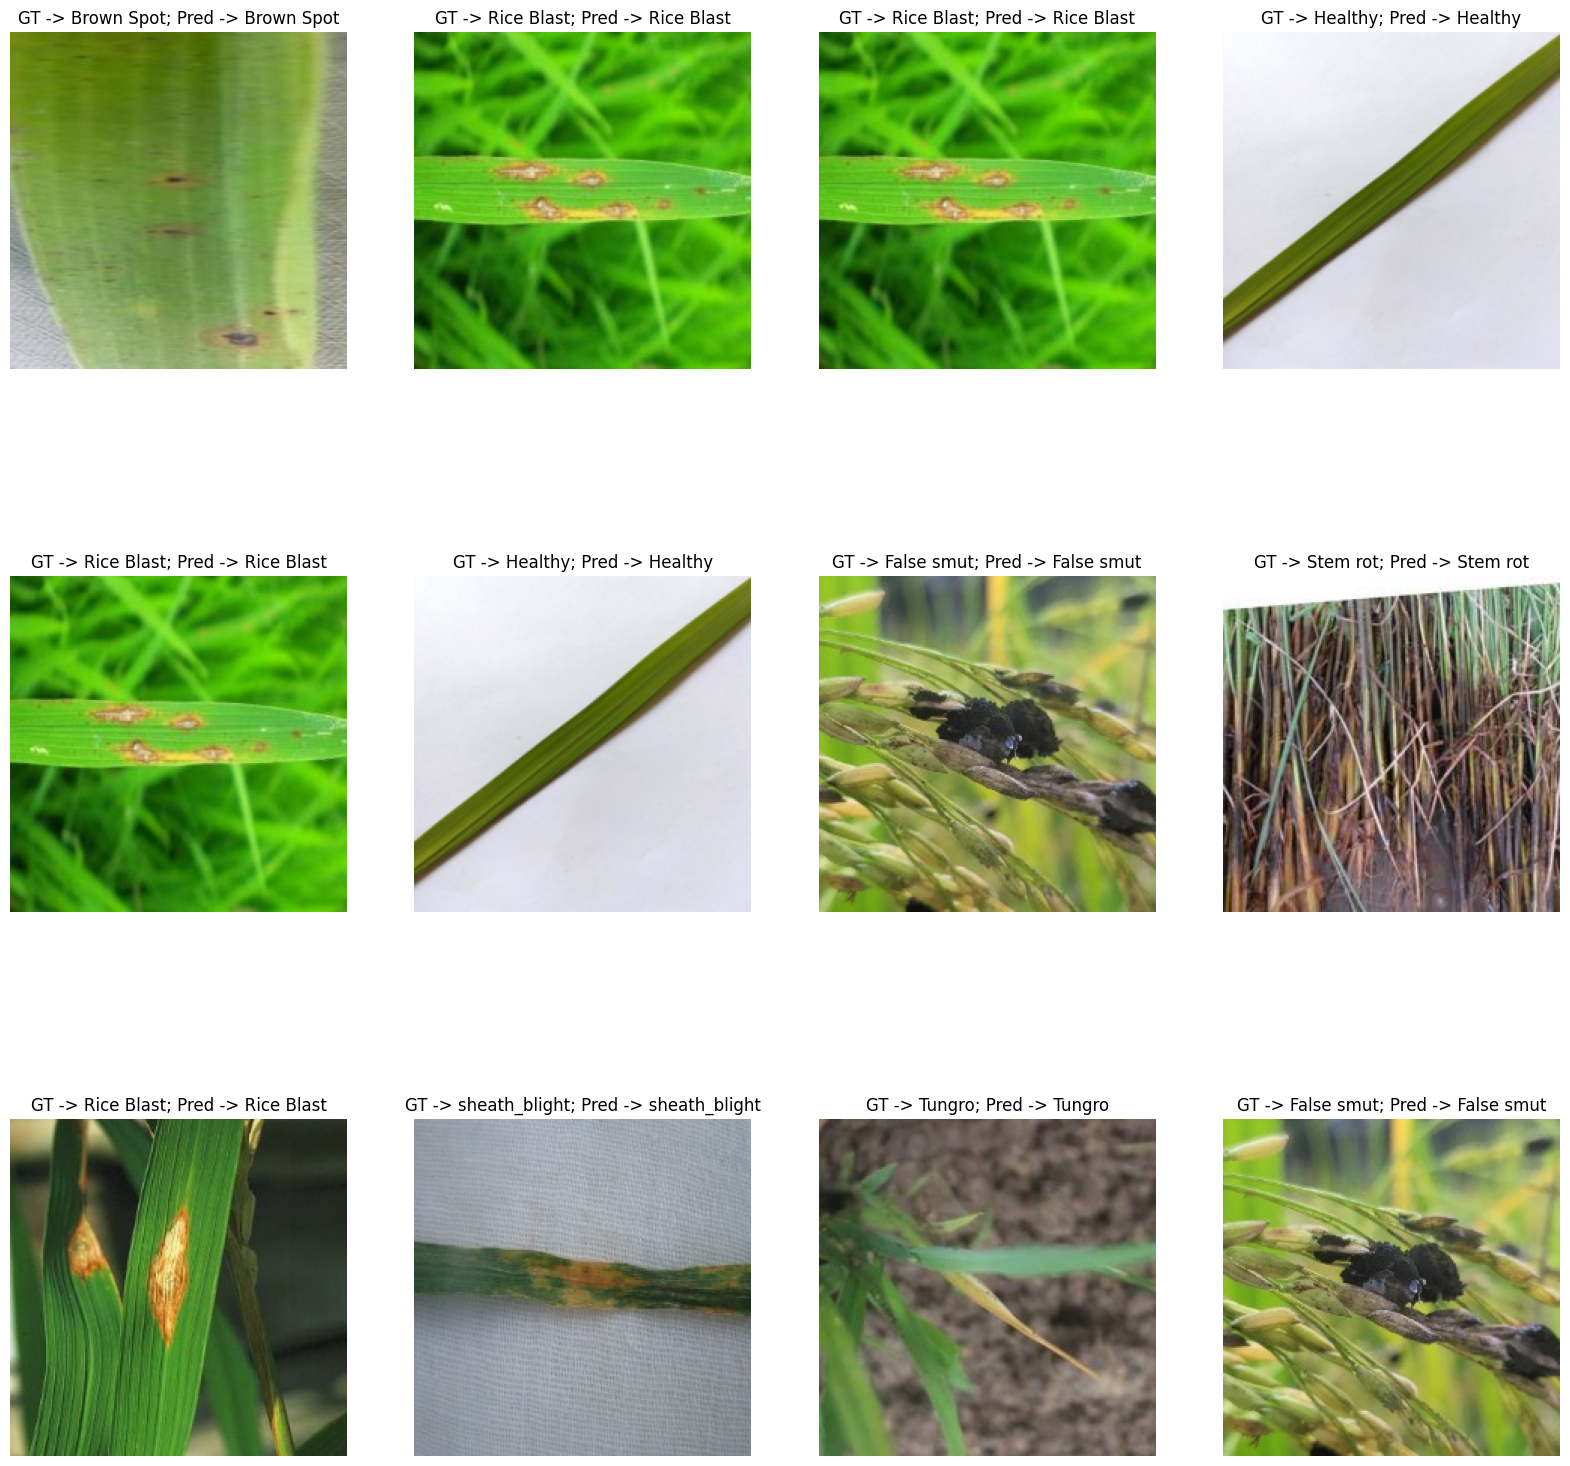

In [22]:
visualize_test(ims, 12, 3)
